## Anime scores prediction project

In this project I have decided to try and predcit the users scores of anime shows from the site myanimelist.net, which is one of the biggest database for anime and manga in the internet that also function as a community hub for anime lovers all over the world! 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from random import randint
from time import sleep
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

Firstly I needed to the acquire the data from the site using crawling and scrapping methods that were taught in class. 
Using beautifulsoup and requests.
I have also created the sleep_mili_seconds and wait_time functions in order to make sure I don't overload the site with too many requests at once and to prevent the site from seeing my craweler as a bot.

In [2]:
def sleep_mili_seconds(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def wait_time():
    start = time.time()
    sleep_mili_seconds(randint(1, 250))

In [3]:
type_list =[]
episodes_list=[]
duration_list=[]
year_list=[]
titles_list=[]
genre_list =[]
score_list=[]
members_list=[]
studios_list=[]
source_list=[]
demographic_list=[]
themes_list=[]


url = 'https://myanimelist.net/anime/genre/'
category_list = ['1/Action', '2/Adventure', '5/Avant_Garde', '46/Award_Winning', '28/Boys_Love',
                 '4/Comedy', '8/Drama', '10/Fantasy', '26/Girls_Love', '47/Gourmet', '14/Horror',
                 '7/Mystery', '22/Romance', '24/Sci-Fi', '36/Slice_of_Life', '30/Sports', '37/Supernatural', '41/Suspense']

for category in category_list:
    i=1
    new_url = url+category+'?page='+str(i)
    response = requests.get(new_url)
    while response.status_code != 404:
        wait_time()
        anime_soup = BeautifulSoup(response.text)
        titles=anime_soup.find_all('h2', class_ = 'h2_anime_title')
        type_year_episdoes_duration =anime_soup.find_all('div', class_ = 'info')
        genres = anime_soup.find_all('div', class_ = 'genres-inner js-genre-inner')
        scores_members = anime_soup.find_all('div', class_='scormem-container')
        studio_source_demogrpahic_theme=anime_soup.find_all('div', class_='properties')

        for title in titles:
            name = title.find('a').text
            titles_list.append(name)

        for info in type_year_episdoes_duration:
            e = info.find_all()
            type_year =e[0].text
            split_type_year =re.split(',',type_year)
            episodes =e[3].text
            duration=e[4].text
            type_list.append(split_type_year[0])
            year_list.append(split_type_year[1])
            episodes_list.append(episodes)
            duration_list.append(duration)

        for g in range (len(genres)):
            genre = genres[g].text.replace('\n\n',',')
            genre=genre.replace('\n', '')
            genre_list.append(genre)

        for s in scores_members:
            score_memeber = s.text.replace('\n', '')
            split_to_scores_members = re.split('        ',score_memeber)
            score_list.append(split_to_scores_members[0])
            members_list.append(split_to_scores_members[1])

        for info in studio_source_demogrpahic_theme:
            studios=info.find_all('span', class_= 'item')[0]
            for studio in studios:
                stud=studio.text
                studios_list.append(stud)

        for info in studio_source_demogrpahic_theme:
            s_s_d_t=info.find_all('span', class_= 'caption')
            if  not info.find(lambda tag:'Demographic' in tag.text) and not info.find(lambda tag:'Demographics' in tag.text):
                demographic_list.append(None)
            if not info.find(lambda tag:'Themes' in tag.text) and not info.find(lambda tag:'Theme' in tag.text):
                themes_list.append(None)
            for ssdt in s_s_d_t:   
                is_ssdt=ssdt.text
                if is_ssdt == 'Demographic' or is_ssdt == 'Demographics':
                    demographic = ssdt.next_sibling.text
                    demographic_list.append(demographic)
                if is_ssdt == 'Source':
                    source = ssdt.next_sibling.text
                    source_list.append(source)
                if is_ssdt == 'Themes' or is_ssdt == 'Theme':
                    theme = ssdt.next_sibling.text
                    themes_list.append(theme)

        i=i+1
        new_url = url+category+'?page='+str(i)
        response = requests.get(new_url)

In [4]:
raw_df = pd.DataFrame({'Titles':titles_list,
                      'Type':type_list, 
                      'Episodes':episodes_list, 
                      'Episode duration':duration_list, 
                      'Year':year_list,
                       'Demographic':demographic_list,
                      'Genres':genre_list,
                      'Theme':themes_list, 
                      'Studio':studios_list,
                      'Source':source_list,
                      'Members':members_list,
                       'Score':score_list})
raw_df

In [5]:
raw_df.to_csv('Anime_list.csv', index=False)

In [6]:
raw_df_csv=pd.read_csv('Anime_list.csv')
raw_df_csv

,Titles,Type,Episodes,Episode duration,Year,Demographic,Genres,Theme,Studio,Source,Members,Score
0,Shingeki no Kyojin,TV,25 eps,24 min,2013,Shounen,"Action,Award Winning,Drama,Suspense",Gore,Wit Studio,Manga,3.6M,8.53
1,Fullmetal Alchemist: Brotherhood,TV,64 eps,24 min,2009,Shounen,"Action,Adventure,Drama,Fantasy",Military,Bones,Manga,3.1M,9.11
2,One Punch Man,TV,12 eps,24 min,2015,Seinen,"Action,Comedy",Adult Cast,Madhouse,Web manga,3.0M,8.50
3,Sword Art Online,TV,25 eps,23 min,2012,NaN,"Action,Adventure,Fantasy,Romance",Love Polygon,A-1 Pictures,Light novel,2.9M,7.20
4,Boku no Hero Academia,TV,13 eps,24 min,2016,Shounen,Action,School,Bones,Manga,2.8M,7.91
...,...,...,...,...,...,...,...,...,...,...,...,...
35012,Liwu,Movie,1 ep,15 min,2012,NaN,"Drama,Suspense",NaN,Unknown,Original,54,NaN
35013,Baozou Kongbu Gushi 3rd Season,ONA,10 eps,6 min,2015,NaN,"Horror,Suspense",NaN,Unknown,NaN,52,NaN
35014,Hei He,ONA,1 ep,12 min,2019,NaN,"Action,Suspense",Psychological,Unknown,Original,43,NaN
35015,Sangsil-ui Jib,Movie,1 ep,9 min,2022,NaN,"Avant Garde,Suspense",Psychological,Unknown,Original,35,NaN


Now I finally have my raw data frame, 35k enteries!
I will add a brief explanation about each column in the data frame before moving on to the next stage.

titles: the english name of the anime.

type: categorize anime into whether it's a regular anime series which will labeled as TV,
movie: if it's a stand alone movie,
ONA: (Original net animation) an anime that was release directly to the internet rather than TV,
OVA: (Original video animation) extra content to the anime which doesnt release on TV as part of the regular show,
Special: extra content to the anime that was released only on the DVD/Blue-ray versions of the animel,
Music: an animated music clip.

episodes: the number of episodes the anime have.

duration: how long each episode lasts.

year: the year the anime was released on.

demographic: anime is categorized into demographic groups of age/gender in which the content is aiming for, we have 5 different demographics groups:
Shonen: For young teenage boys, roughly between 12-18.
Seinen: For young adult males or younger men, roughly between 18-40.
Shojo: For young teenage girls, roughly between 8-18.
kids: for young kids till the age of 12.
Josei: For adult females or younger women, roughly between 18-40.

genres: the genres in which the anime belongs to.

studio: the anime studio that animated the show.

source: the source material that the anime is based on, for example manga, novel, game and more.

theme: theme act as a secondary genere to the anime.

members: the amount of members that have added the anime to their personal list on the site for example as completed, watching, dropped, etc...

score: the user score the anime was given on the site range from 0-10.

# Data cleaning

Now I will start with initial data cleaning on the raw data frame.

Firstly since I took the anime by generes, I bound to have duplicates in my data frame since many anime naturally fall under more than one genre.

In [7]:
df_no_dup = raw_df_csv.drop_duplicates()
df_no_dup

,Titles,Type,Episodes,Episode duration,Year,Demographic,Genres,Theme,Studio,Source,Members,Score
0,Shingeki no Kyojin,TV,25 eps,24 min,2013,Shounen,"Action,Award Winning,Drama,Suspense",Gore,Wit Studio,Manga,3.6M,8.53
1,Fullmetal Alchemist: Brotherhood,TV,64 eps,24 min,2009,Shounen,"Action,Adventure,Drama,Fantasy",Military,Bones,Manga,3.1M,9.11
2,One Punch Man,TV,12 eps,24 min,2015,Seinen,"Action,Comedy",Adult Cast,Madhouse,Web manga,3.0M,8.50
3,Sword Art Online,TV,25 eps,23 min,2012,NaN,"Action,Adventure,Fantasy,Romance",Love Polygon,A-1 Pictures,Light novel,2.9M,7.20
4,Boku no Hero Academia,TV,13 eps,24 min,2016,Shounen,Action,School,Bones,Manga,2.8M,7.91
...,...,...,...,...,...,...,...,...,...,...,...,...
34989,Sirotsumekusa,Movie,1 ep,72 min,2020,NaN,Suspense,NaN,HoriPro,Original,205,NaN
34991,Bao Mu,Movie,1 ep,9 min,2016,NaN,Suspense,Adult Cast,Unknown,Original,160,NaN
34996,Panspermia,Music,1 ep,3 min,2021,NaN,Suspense,Music,Unknown,Original,104,NaN
35006,Shei Pa Shei,Movie,1 ep,9 min,1992,Kids,Suspense,NaN,Shanghai Animation Film Studio,Original,61,NaN


I could see that some anime are missing a score value, this is due to some anime not being released yet or they have too low amount of votes to receive a score, since I am trying to predict scores of anime I can't use things like average or median to fill the missing values with out messing with the prediction process, so I will have to remove those anime entirely.

In [8]:
df_drop_nan = df_no_dup.dropna(subset=['Score'])
df_drop_nan

,Titles,Type,Episodes,Episode duration,Year,Demographic,Genres,Theme,Studio,Source,Members,Score
0,Shingeki no Kyojin,TV,25 eps,24 min,2013,Shounen,"Action,Award Winning,Drama,Suspense",Gore,Wit Studio,Manga,3.6M,8.53
1,Fullmetal Alchemist: Brotherhood,TV,64 eps,24 min,2009,Shounen,"Action,Adventure,Drama,Fantasy",Military,Bones,Manga,3.1M,9.11
2,One Punch Man,TV,12 eps,24 min,2015,Seinen,"Action,Comedy",Adult Cast,Madhouse,Web manga,3.0M,8.50
3,Sword Art Online,TV,25 eps,23 min,2012,NaN,"Action,Adventure,Fantasy,Romance",Love Polygon,A-1 Pictures,Light novel,2.9M,7.20
4,Boku no Hero Academia,TV,13 eps,24 min,2016,Shounen,Action,School,Bones,Manga,2.8M,7.91
...,...,...,...,...,...,...,...,...,...,...,...,...
34946,Bondage Game: Shinsou no Reijou-tachi - Shinso...,Special,1 ep,26 min,2003,NaN,"Suspense,Hentai",Psychological,ORADA COMPANY,Visual novel,2.8K,5.12
34971,Da Shi Jie,Movie,1 ep,77 min,2018,NaN,Suspense,Psychological,Unknown,Original,847,5.82
34975,Boku no Sensou,Music,1 ep,4 min,2022,NaN,Suspense,Music,Rabbit Machine,NaN,763,6.39
34982,Uchiko no Mama to Okaasan,ONA,1 ep,0 min,2011,NaN,Suspense,NaN,Unknown,Original,389,5.02


The episodes, episode duration and members columns got saved as strings with the words eps, min,k and m in them, since I need numbers only for the machine learning model i will change those to integers and get rid of the words part.
(I had 60 anime with unknown number of episodes, most likely due to them still running since its such a little amount I have decided to just drop them)

In [9]:
df_remove_string = df_drop_nan.copy()
df_remove_string['Episode duration'] = df_drop_nan['Episode duration'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

df_remove_string=df_remove_string.replace('? eps', 'Unknown')
df_remove_string = df_remove_string[df_remove_string["Episodes"].str.contains("Unknown") == False]
df_remove_string['Episodes'] = df_drop_nan['Episodes'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

e_list = [i.replace('K','e3').replace('M','e6') for i in df_remove_string['Members']]
values = [float(i) for i in e_list]
my_new_list = [f'{int(i):}' for i in values]
my_new_list=list(map(int, my_new_list))
my_new_list
df_remove_string['Members']=my_new_list
df_remove_string

,Titles,Type,Episodes,Episode duration,Year,Demographic,Genres,Theme,Studio,Source,Members,Score
0,Shingeki no Kyojin,TV,25,24,2013,Shounen,"Action,Award Winning,Drama,Suspense",Gore,Wit Studio,Manga,3600000,8.53
1,Fullmetal Alchemist: Brotherhood,TV,64,24,2009,Shounen,"Action,Adventure,Drama,Fantasy",Military,Bones,Manga,3100000,9.11
2,One Punch Man,TV,12,24,2015,Seinen,"Action,Comedy",Adult Cast,Madhouse,Web manga,3000000,8.50
3,Sword Art Online,TV,25,23,2012,NaN,"Action,Adventure,Fantasy,Romance",Love Polygon,A-1 Pictures,Light novel,2900000,7.20
4,Boku no Hero Academia,TV,13,24,2016,Shounen,Action,School,Bones,Manga,2800000,7.91
...,...,...,...,...,...,...,...,...,...,...,...,...
34946,Bondage Game: Shinsou no Reijou-tachi - Shinso...,Special,1,26,2003,NaN,"Suspense,Hentai",Psychological,ORADA COMPANY,Visual novel,2800,5.12
34971,Da Shi Jie,Movie,1,77,2018,NaN,Suspense,Psychological,Unknown,Original,847,5.82
34975,Boku no Sensou,Music,1,4,2022,NaN,Suspense,Music,Rabbit Machine,NaN,763,6.39
34982,Uchiko no Mama to Okaasan,ONA,1,0,2011,NaN,Suspense,NaN,Unknown,Original,389,5.02


Now I will deal with missing values in the data.

In [10]:
df_remove_string.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12239 entries, 0 to 34987
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Titles            12239 non-null  object 
 1   Type              12239 non-null  object 
 2   Episodes          12239 non-null  int32  
 3   Episode duration  12239 non-null  int32  
 4   Year              12239 non-null  object 
 5   Demographic       3890 non-null   object 
 6   Genres            12239 non-null  object 
 7   Theme             7650 non-null   object 
 8   Studio            12239 non-null  object 
 9   Source            10786 non-null  object 
 10  Members           12239 non-null  int64  
 11  Score             12239 non-null  float64
dtypes: float64(1), int32(2), int64(1), object(8)
memory usage: 1.1+ MB


There is missing data in the source, demographic and and theme columns, I also can see that year is saved as string rather than int so I will also fix that while at it.

In [11]:
df_remove_string[df_remove_string['Year'].str.contains(' -')]

,Titles,Type,Episodes,Episode duration,Year,Demographic,Genres,Theme,Studio,Source,Members,Score
18498,Tottoko Hamtarou no Tottoko Taisetsu!! Koutsuu...,OVA,1,14,-,Kids,Drama,Educational,Unknown,Manga,549,6.27
18528,Honoo no Alpenrose: Ai no Symphony Ongaku-hen,OVA,1,29,-,Shoujo,"Drama,Romance",Historical,Tatsunoko Production,Manga,488,5.85
18558,Saru Kani Gassen,Movie,1,7,-,NaN,Drama,NaN,Unknown,Other,439,5.13
33022,Captain Tsubasa no Shouka Sakusen,OVA,1,15,-,Kids,Sports,Educational,Unknown,Manga,703,6.24
34499,Hanako,Movie,1,4,-,NaN,Supernatural,School,Unknown,Original,1300,5.87


There are only 5 rows with unknown year, since 5 out of 12k is really low I decided to remove those, , will also remove one anime with missing type.

In [12]:
df_remove_NaN = df_remove_string.copy()
df_remove_NaN = df_remove_NaN[df_remove_NaN["Type"].str.contains('-') == False]
df_remove_NaN = df_remove_NaN[df_remove_NaN["Year"].str.contains(' -') == False]
df_remove_NaN['Year']=list(map(int, df_remove_NaN['Year']))

Next I will move to the source column

In [13]:
df_remove_NaN['Source'].describe()

count     10781
unique       16
top       Manga
freq       3603
Name: Source, dtype: object

I have decided to fill the missing source values with the top value.

In [14]:
df_remove_NaN['Source']=df_remove_string['Source'].fillna('Manga')

I was rather confused as to why so so many anime are missing a demographic tag ( about 70%), after some research into it I have found out that only anime that have a manga as source get demographic tag since it originate from the magazines in which the manga is published in, and since in this project I check anime from all sources there is just too much missing demogrpahic tags to be able to fill it in any reliable way, so the only option will be to drop the demographic column, I couldn't find an explanation to the theme column but since over 60% of it is also missing I have decided to drop it as well.

In [15]:
df_remove_NaN = df_remove_NaN.drop(['Demographic', 'Theme'], axis=1)
df_cleaned = df_remove_NaN.copy()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 34987
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Titles            12233 non-null  object 
 1   Type              12233 non-null  object 
 2   Episodes          12233 non-null  int32  
 3   Episode duration  12233 non-null  int32  
 4   Year              12233 non-null  int64  
 5   Genres            12233 non-null  object 
 6   Studio            12233 non-null  object 
 7   Source            12233 non-null  object 
 8   Members           12233 non-null  int64  
 9   Score             12233 non-null  float64
dtypes: float64(1), int32(2), int64(2), object(5)
memory usage: 955.7+ KB


# pre outliers EDA

Now That i dealt with all missing data i can do initial EDA to see if everything in the data makes sense or if I have any outliers.

In [16]:
df_cleaned.describe()

,Episodes,Episode duration,Year,Members,Score
count,12233.000000,12233.000000,12233.000000,1.223300e+04,12233.000000
mean,12.953486,27.173220,2006.590207,7.000887e+04,6.521184
std,49.437925,26.606456,14.170268,2.093261e+05,0.914613
min,1.000000,0.000000,1917.000000,1.720000e+02,1.850000
25%,1.000000,8.000000,2001.000000,1.500000e+03,5.930000
50%,3.000000,23.000000,2011.000000,6.800000e+03,6.540000
75%,12.000000,27.000000,2016.000000,4.100000e+04,7.190000
max,3057.000000,168.000000,2023.000000,3.600000e+06,9.110000


I can't spot any obvious outliers in the data so I have decided to make some graphs to show the Distribution of data in each column to get a better look at things.

In [17]:
def histogram_maker (df,column_name):
    fig, ax = plt.subplots(figsize=(18, 10))
    fg = sns.histplot(df[column_name],ax=ax)
    fg.set_title(column_name+' ' "Histogram")
    fg.set_xlabel(column_name)
    plt.show()

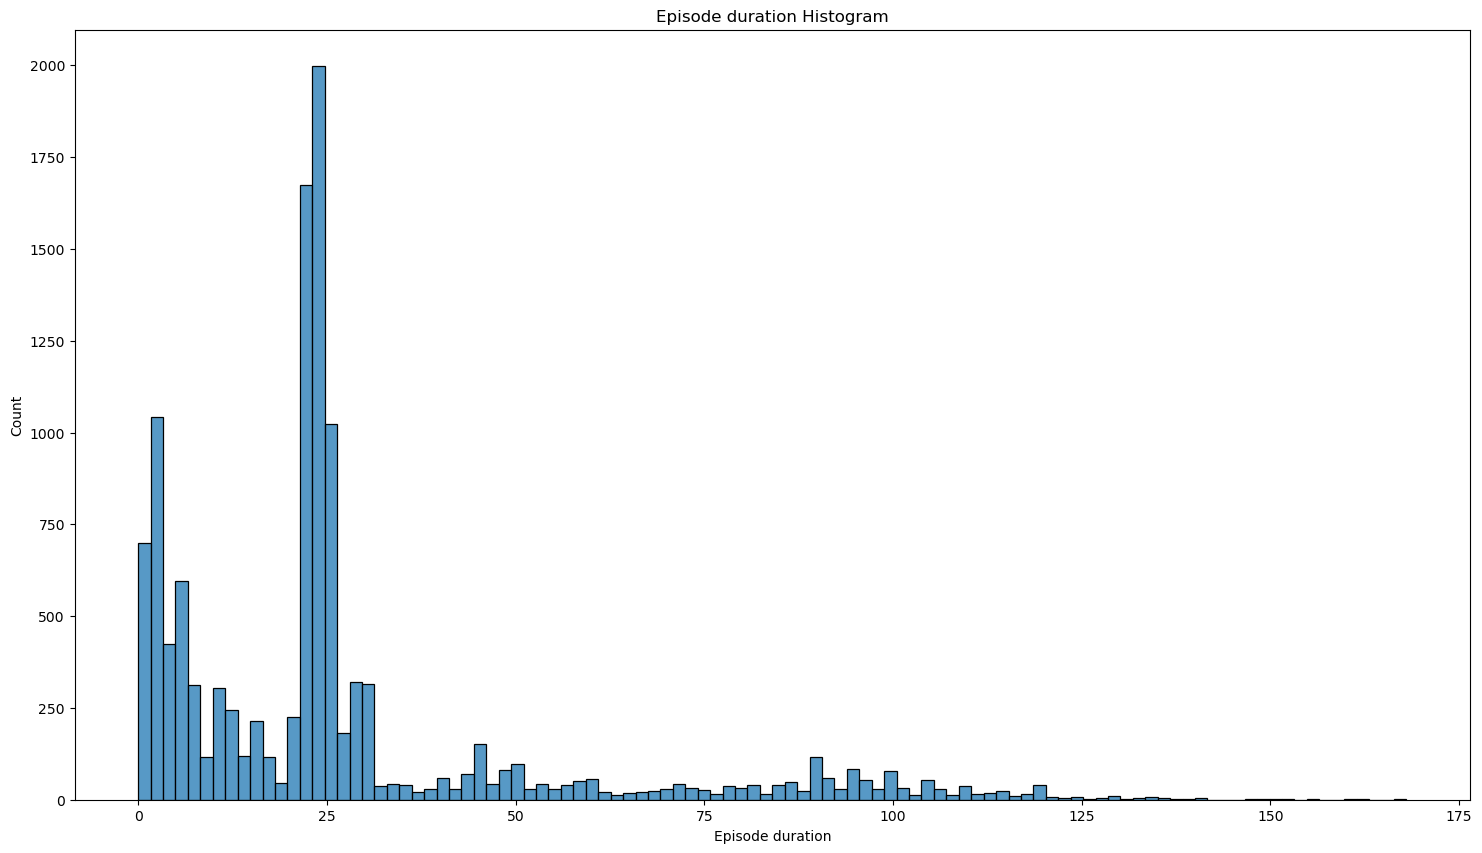

In [18]:
histogram_maker(df_cleaned,'Episode duration')

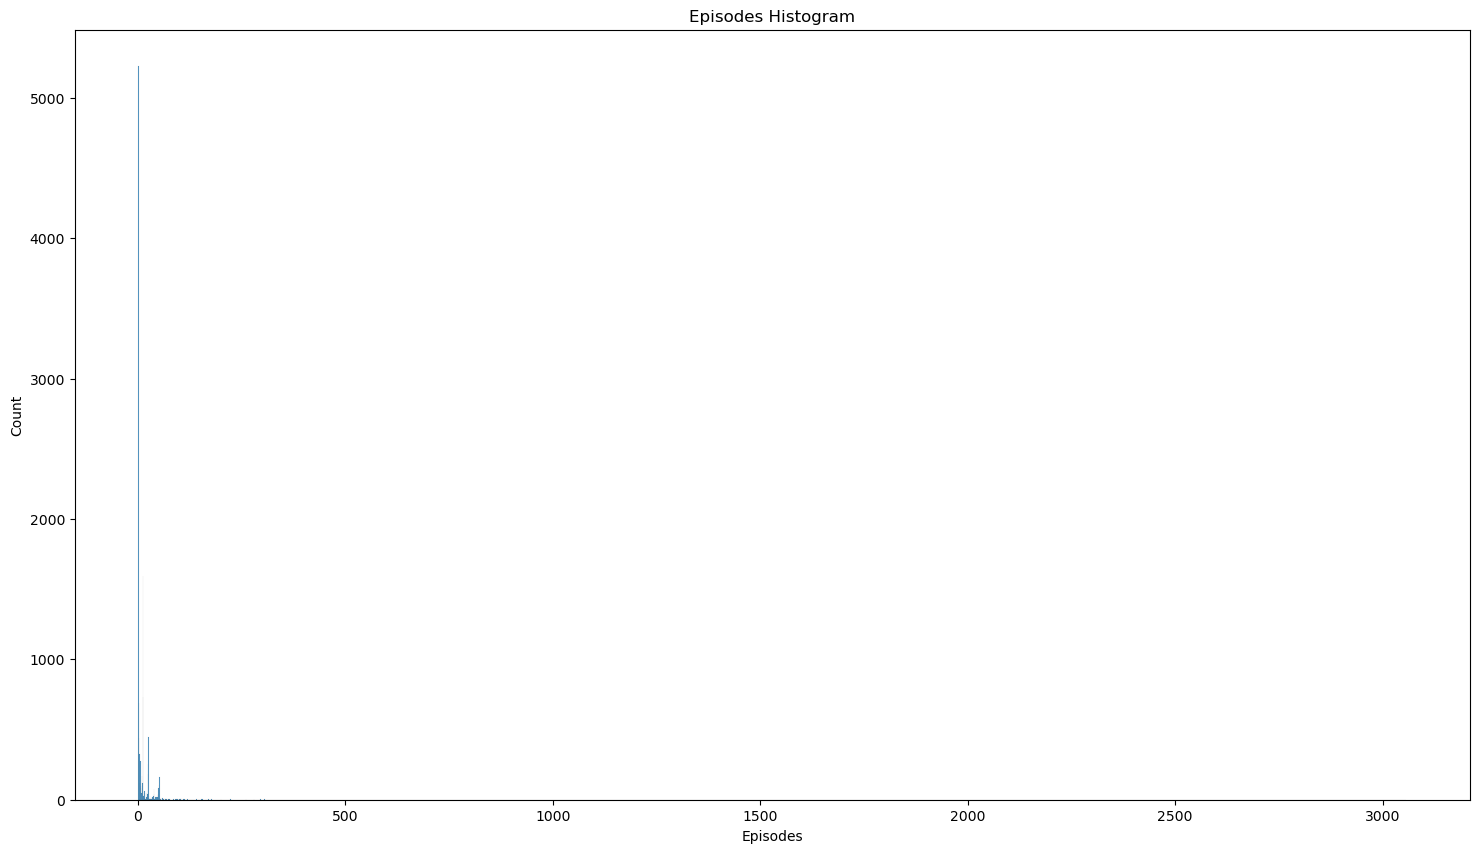

In [19]:
histogram_maker(df_cleaned, 'Episodes')

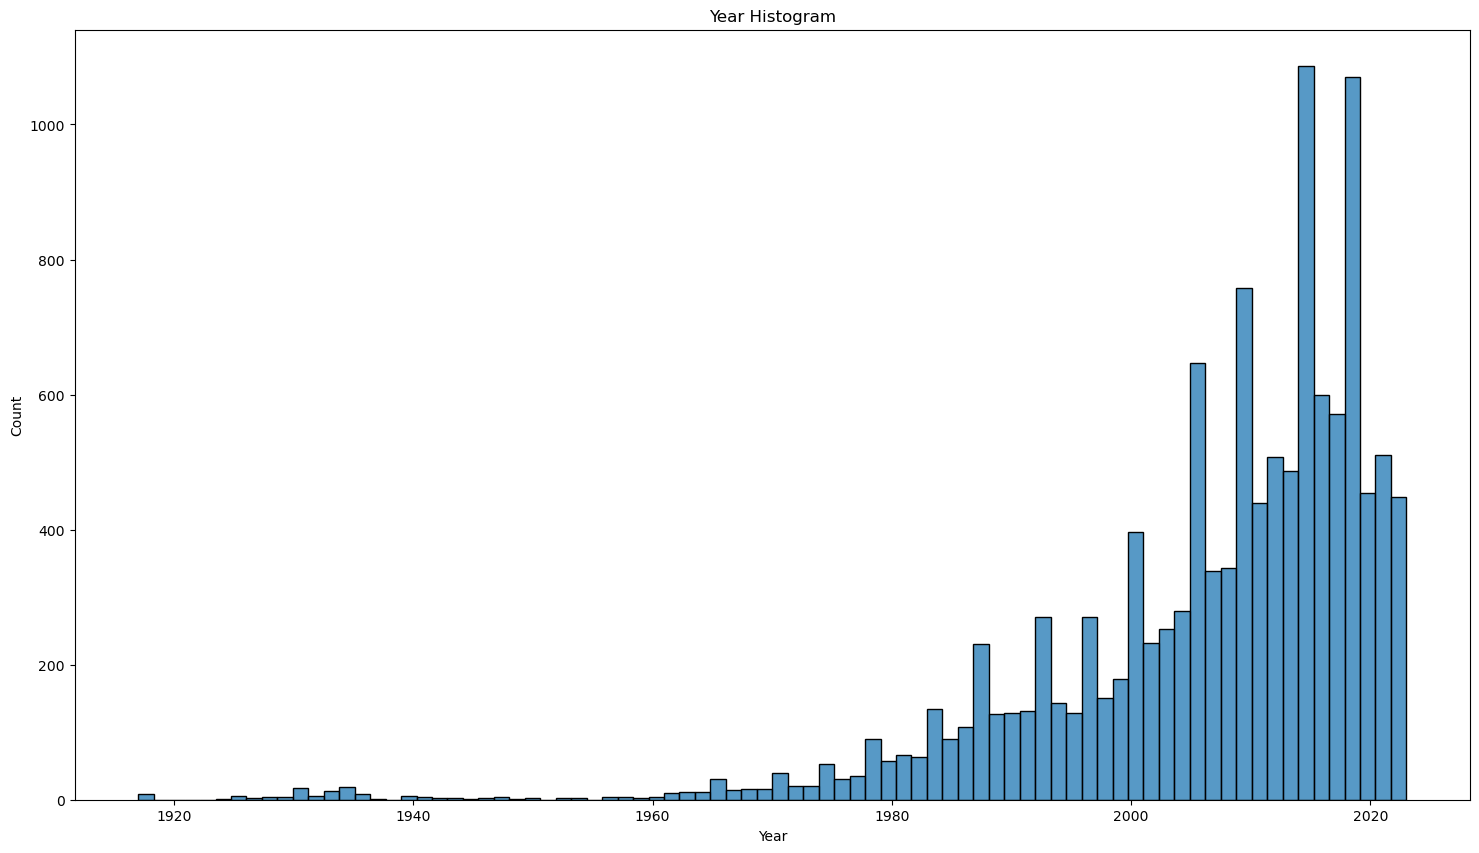

In [20]:
histogram_maker(df_cleaned, 'Year')

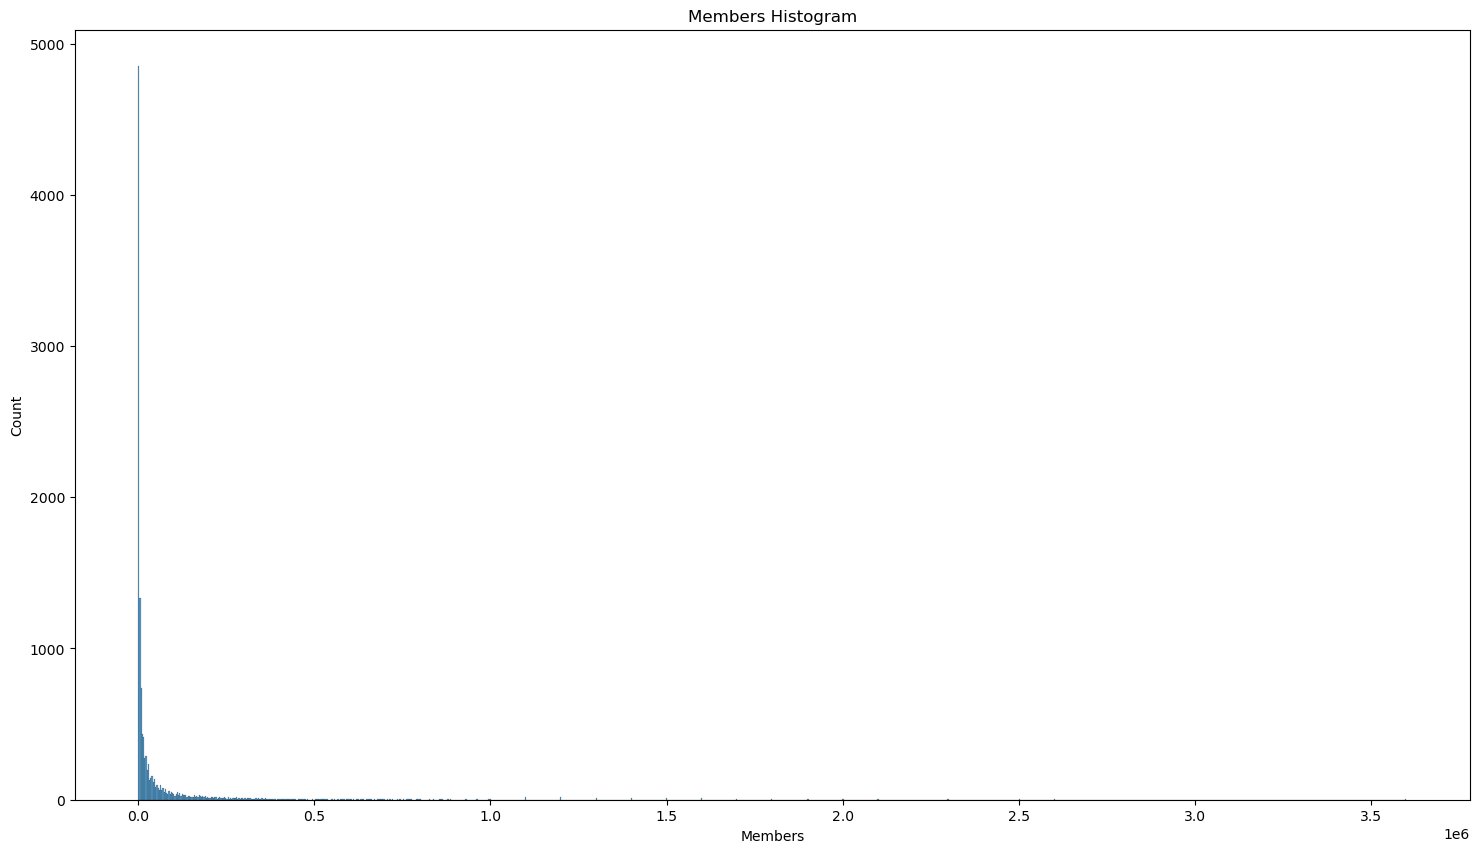

In [21]:
histogram_maker(df_cleaned, 'Members')

I can see outliers in episodes duration, episodes count and memebers count, I will use IQR with capping to fix them, since median or avarege will dismiss longer movies, long running anime that got many episodes and very popular anime that got added by many people to theri list, all of which I feel won't be true to the data and mess with the prediction later on.

In [22]:
def outliers(col_list):
    df_no_outliers = df_cleaned.copy()
    for col in col_list:
        Q1 = np.percentile(df_no_outliers[col], 25)
        Q3 = np.percentile(df_no_outliers[col], 75)
        IQR = Q3-Q1
        df_no_outliers.loc[(df_no_outliers[col] < Q1 - 1.5 * IQR), [col]] = Q1
        df_no_outliers.loc[(df_no_outliers[col] > Q3 + 1.5 * IQR), [col]] = Q3
    return df_no_outliers

In [23]:
cols = ['Episodes', 'Episode duration', 'Members']
df_after_IQR = outliers(cols)
df_after_IQR.describe()

,Episodes,Episode duration,Year,Members,Score
count,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000
mean,7.098422,19.673751,2006.590207,18412.860541,6.521184
std,7.365213,11.627471,14.170268,21918.451791,0.914613
min,1.000000,0.000000,1917.000000,172.000000,1.850000
25%,1.000000,8.000000,2001.000000,1500.000000,5.930000
50%,3.000000,23.000000,2011.000000,6800.000000,6.540000
75%,12.000000,27.000000,2016.000000,41000.000000,7.190000
max,28.000000,55.000000,2023.000000,100000.000000,9.110000


This still feels too extreme, turning long running anime into 12 episodes anime, long movies into about episode length and anime with members in the millions of users that have added to their list into just 100k, I have decided to choose more suitable numbers to change the outliers into using the histograms I have made earlier and boxplots.

<AxesSubplot:xlabel='Episodes'>

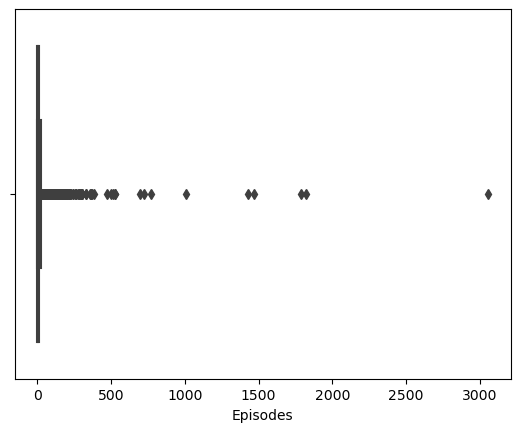

In [24]:
sns.boxplot(x=df_cleaned['Episodes'])

<AxesSubplot:xlabel='Episode duration'>

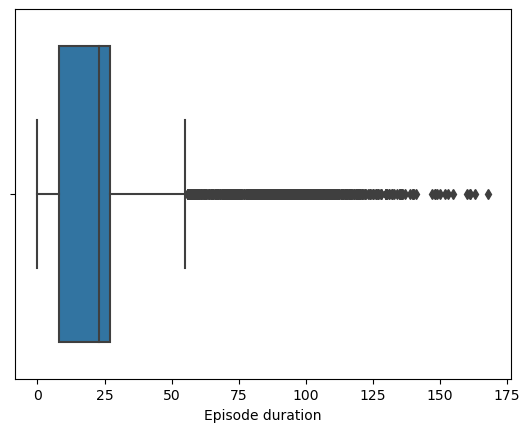

In [25]:
sns.boxplot(x=df_cleaned['Episode duration'])

<AxesSubplot:xlabel='Members'>

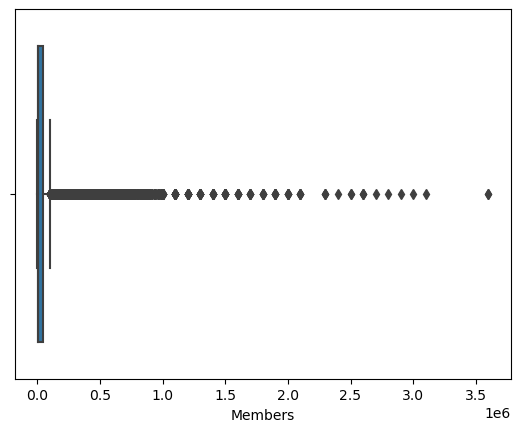

In [26]:
sns.boxplot(x=df_cleaned['Members'])

In [27]:
df_outliers = df_cleaned.copy()

Using the histograph and boxplot i decided on a range of numbers to check how many enteries are for that value and chose the one that seemed most suitable.

In [28]:
for num in range(50,310,10):
    count = np.count_nonzero(df_outliers['Episodes'] > num)
    print(f"the number of anime with over {num} episodes is {count}" )

the number of anime with over 50 episodes is 588
the number of anime with over 60 episodes is 267
the number of anime with over 70 episodes is 222
the number of anime with over 80 episodes is 181
the number of anime with over 90 episodes is 175
the number of anime with over 100 episodes is 148
the number of anime with over 110 episodes is 113
the number of anime with over 120 episodes is 99
the number of anime with over 130 episodes is 92
the number of anime with over 140 episodes is 86
the number of anime with over 150 episodes is 76
the number of anime with over 160 episodes is 66
the number of anime with over 170 episodes is 57
the number of anime with over 180 episodes is 51
the number of anime with over 190 episodes is 50
the number of anime with over 200 episodes is 44
the number of anime with over 210 episodes is 41
the number of anime with over 220 episodes is 38
the number of anime with over 230 episodes is 35
the number of anime with over 240 episodes is 34
the number of anim

In [29]:
df_outliers.loc[(df_outliers['Episodes'] > 60), ['Episodes']] = 60

In [30]:
for num in range(50,180,10):
    count = np.count_nonzero(df_outliers['Episode duration'] > num)
    print(f"the number of episodes longer than {num} minutes is {count}" )

the number of episodes longer than 50 minutes is 1587
the number of episodes longer than 60 minutes is 1306
the number of episodes longer than 70 minutes is 1182
the number of episodes longer than 80 minutes is 995
the number of episodes longer than 90 minutes is 712
the number of episodes longer than 100 minutes is 380
the number of episodes longer than 110 minutes is 201
the number of episodes longer than 120 minutes is 77
the number of episodes longer than 130 minutes is 39
the number of episodes longer than 140 minutes is 14
the number of episodes longer than 150 minutes is 8
the number of episodes longer than 160 minutes is 4
the number of episodes longer than 170 minutes is 0


In [31]:
df_outliers.loc[(df_outliers['Episode duration'] > 120), ['Episode duration']] = 120

In [32]:
for num in range(1,11,1):
    count = np.count_nonzero(df_outliers['Episode duration'] < num)
    print(f"the number of episodes shorter than {num} minutes is {count}" )

the number of episodes shorter than 1 minutes is 280
the number of episodes shorter than 2 minutes is 699
the number of episodes shorter than 3 minutes is 1136
the number of episodes shorter than 4 minutes is 1740
the number of episodes shorter than 5 minutes is 2165
the number of episodes shorter than 6 minutes is 2565
the number of episodes shorter than 7 minutes is 2761
the number of episodes shorter than 8 minutes is 2934
the number of episodes shorter than 9 minutes is 3074
the number of episodes shorter than 10 minutes is 3191


In [33]:
df_outliers.loc[(df_outliers['Episode duration'] < 1), ['Episode duration']] = 1

In [34]:
for num in range(100000,3600000,50000):
    count = np.count_nonzero(df_outliers['Members'] > num)
    print(f"the number of anime with more than {num} members is {count}" )

the number of anime with more than 100000 members is 1826
the number of anime with more than 150000 members is 1361
the number of anime with more than 200000 members is 1057
the number of anime with more than 250000 members is 845
the number of anime with more than 300000 members is 702
the number of anime with more than 350000 members is 592
the number of anime with more than 400000 members is 501
the number of anime with more than 450000 members is 436
the number of anime with more than 500000 members is 389
the number of anime with more than 550000 members is 348
the number of anime with more than 600000 members is 316
the number of anime with more than 650000 members is 276
the number of anime with more than 700000 members is 241
the number of anime with more than 750000 members is 225
the number of anime with more than 800000 members is 191
the number of anime with more than 850000 members is 176
the number of anime with more than 900000 members is 155
the number of anime with mor

In [35]:
df_outliers.loc[(df_outliers['Members'] > 200000), ['Members']] = 200000

In [36]:
for num in range(0,1100,100):
    count = np.count_nonzero(df_outliers['Members'] < num)
    print(f"the number of anime with less than {num} members is {count}" )

the number of anime with less than 0 members is 0
the number of anime with less than 100 members is 0
the number of anime with less than 200 members is 6
the number of anime with less than 300 members is 155
the number of anime with less than 400 members is 424
the number of anime with less than 500 members is 766
the number of anime with less than 600 members is 1075
the number of anime with less than 700 members is 1349
the number of anime with less than 800 members is 1626
the number of anime with less than 900 members is 1907
the number of anime with less than 1000 members is 2157


In [37]:
df_outliers.loc[(df_outliers['Members'] < 1000), ['Members']] = 1000

## EDA

Now that i have dealt with outliers I will check how my data looks like.

In [38]:
df_outliers

,Titles,Type,Episodes,Episode duration,Year,Genres,Studio,Source,Members,Score
0,Shingeki no Kyojin,TV,25,24,2013,"Action,Award Winning,Drama,Suspense",Wit Studio,Manga,200000,8.53
1,Fullmetal Alchemist: Brotherhood,TV,60,24,2009,"Action,Adventure,Drama,Fantasy",Bones,Manga,200000,9.11
2,One Punch Man,TV,12,24,2015,"Action,Comedy",Madhouse,Web manga,200000,8.50
3,Sword Art Online,TV,25,23,2012,"Action,Adventure,Fantasy,Romance",A-1 Pictures,Light novel,200000,7.20
4,Boku no Hero Academia,TV,13,24,2016,Action,Bones,Manga,200000,7.91
...,...,...,...,...,...,...,...,...,...,...
34946,Bondage Game: Shinsou no Reijou-tachi - Shinso...,Special,1,26,2003,"Suspense,Hentai",ORADA COMPANY,Visual novel,2800,5.12
34971,Da Shi Jie,Movie,1,77,2018,Suspense,Unknown,Original,1000,5.82
34975,Boku no Sensou,Music,1,4,2022,Suspense,Rabbit Machine,Manga,1000,6.39
34982,Uchiko no Mama to Okaasan,ONA,1,1,2011,Suspense,Unknown,Original,1000,5.02


In [39]:
df_outliers.describe()

,Episodes,Episode duration,Year,Members,Score
count,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000
mean,10.448132,27.108641,2006.590207,38620.281207,6.521184
std,14.425836,26.237671,14.170268,62183.712226,0.914613
min,1.000000,1.000000,1917.000000,1000.000000,1.850000
25%,1.000000,8.000000,2001.000000,1500.000000,5.930000
50%,3.000000,23.000000,2011.000000,6800.000000,6.540000
75%,12.000000,27.000000,2016.000000,41000.000000,7.190000
max,60.000000,120.000000,2023.000000,200000.000000,9.110000


I have decided to check the distribution of scores across all anime to see how they look like.

<Figure size 1500x1000 with 0 Axes>

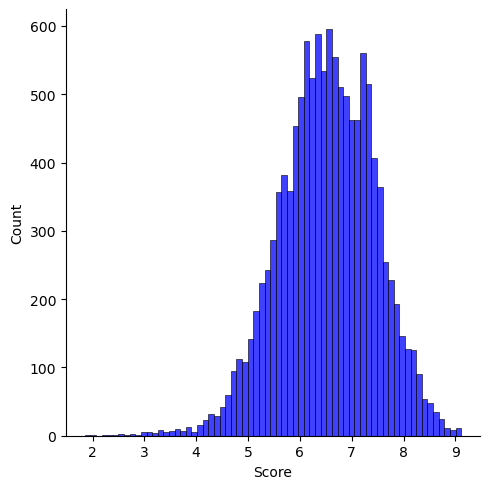

In [40]:
plt.figure(figsize=(15,10))
sns.displot(df_outliers['Score'],color="b")

As shown above most anime is in the 6-7 range which makes sense as most people will consider that score range to be average score for shows.

Now I will check the relation between the different columns and the scores column to see if i can find their relation and patterns.

[Text(0.5, 1.0, 'Years and scores')]

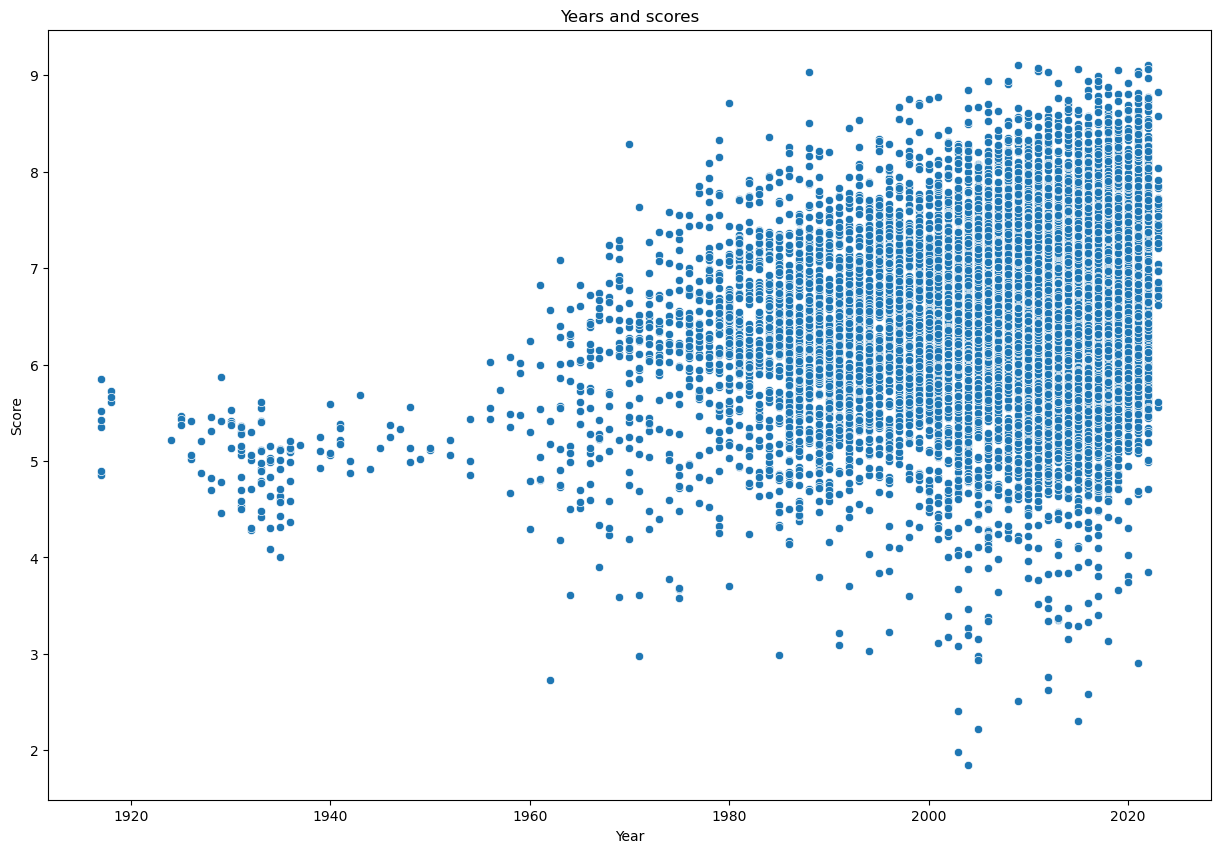

In [41]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df_outliers['Year'], y= df_outliers['Score']).set(title = 'Years and scores')

It seems that anime before 1960 are all in the 4-6 range, and the "worst" anime is in the early 2000's, but other than that it doesnt seem to be a great indicator of anime score.

[Text(0.5, 1.0, 'Members and scores')]

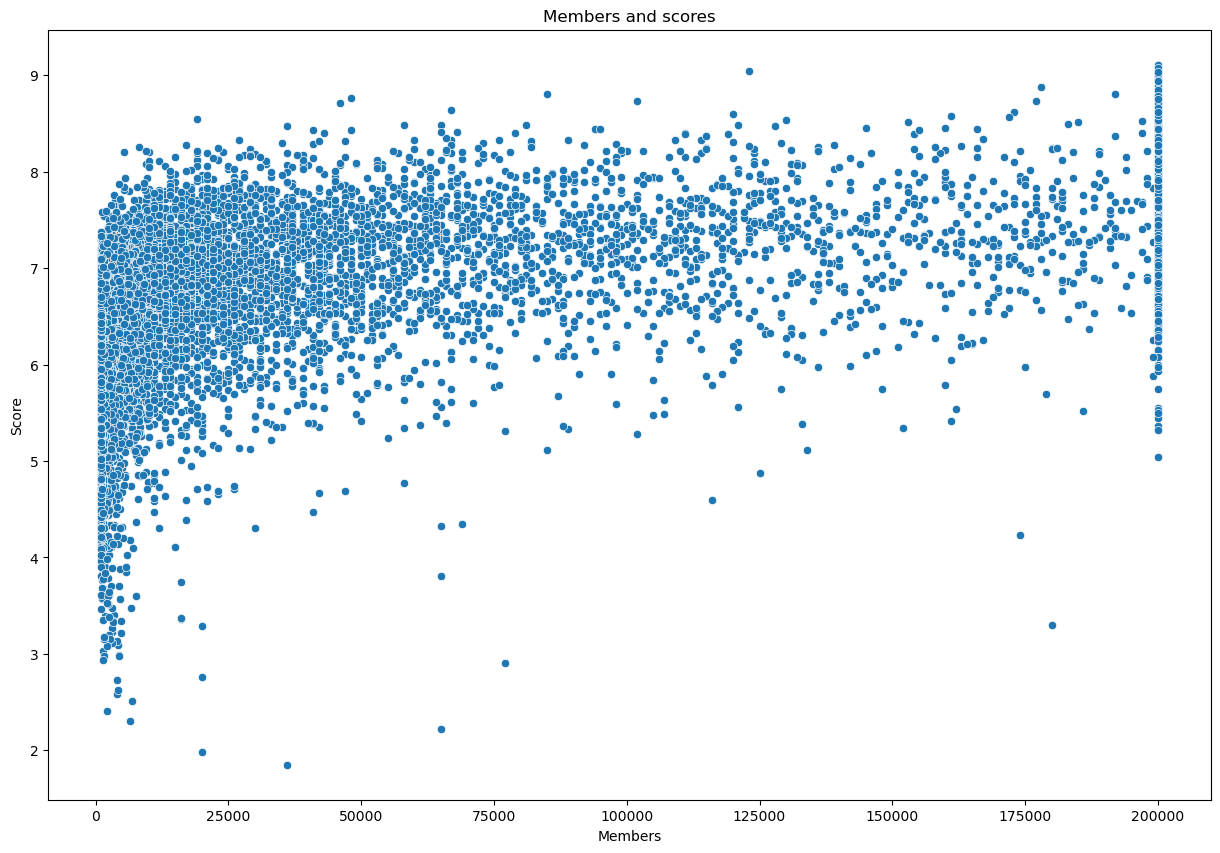

In [42]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df_outliers['Members'], y= df_outliers['Score']).set(title = 'Members and scores')

It seems that anime with low score is mostly with under 25k memebers, and the best scoring ones are from the 200k+ members.
this makes sense as under 25k indicates the anime is not very popular or not very known which will translate to low score in most cases, and the opposite can be said about 200k+, but it seems to mostly find scores of the "edges" anime.

[Text(0.5, 1.0, 'Episodes and scores')]

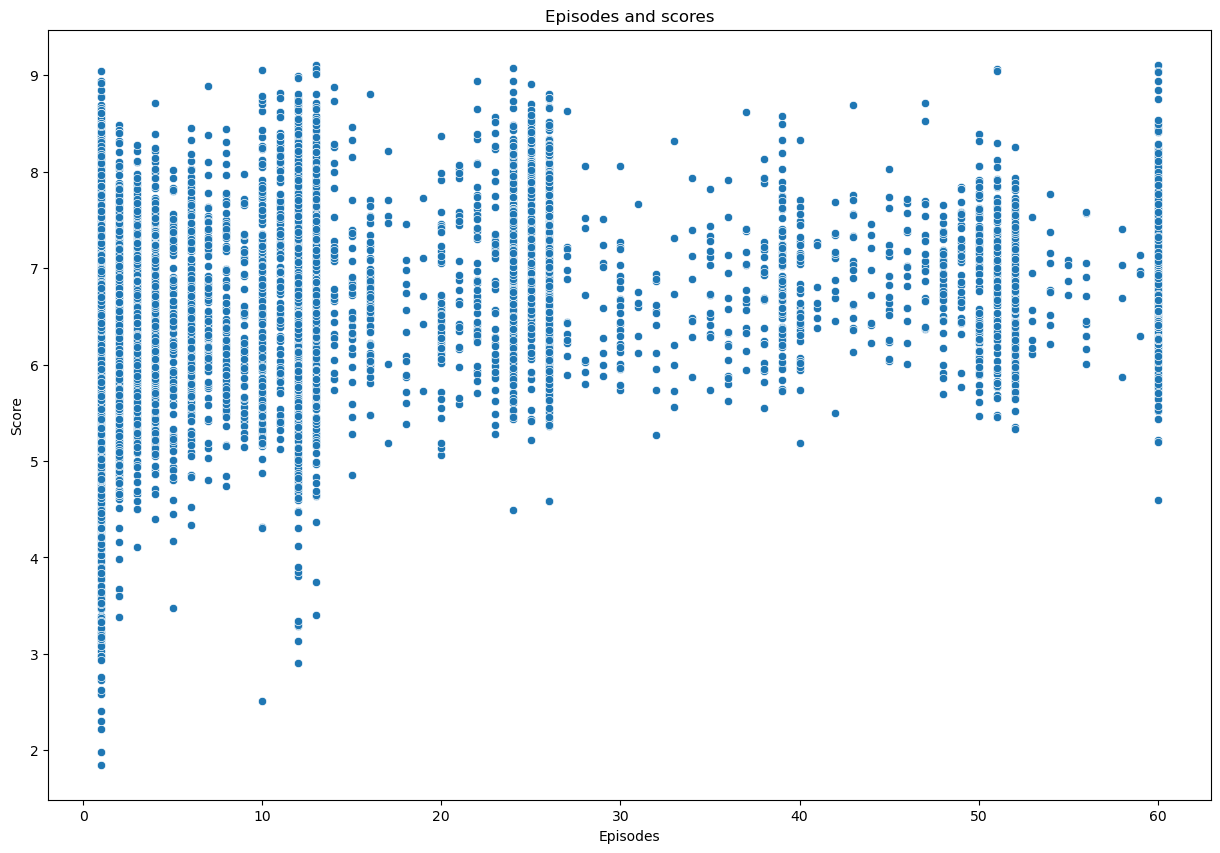

In [43]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df_outliers['Episodes'], y= df_outliers['Score']).set(title = 'Episodes and scores')

There doesnt seem to be much of a relation between number of episodes and scores, I might remove it later on.

[Text(0.5, 1.0, 'Episode duration and scores')]

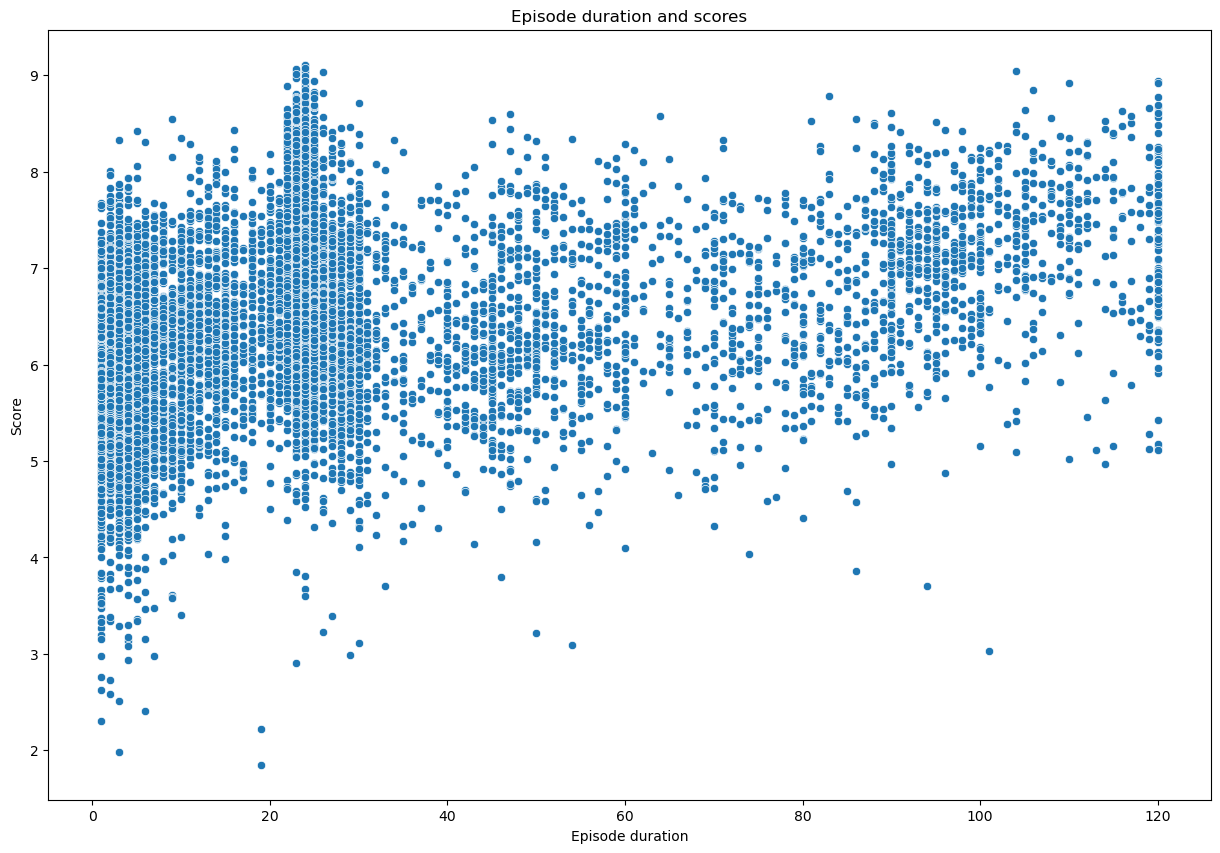

In [44]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df_outliers['Episode duration'], y= df_outliers['Score']).set(title = 'Episode duration and scores')

There is a peak in score around the 20-30 min range which makes sense since that's the length of a regular anime episodes and an other small peak at 110-120 range which is the usual length of movies. also can notice that most of the anime with score lower than 4 have very short duration, this is most likely due to anime that short being mostly promotional media and short specials.
this tells me that there is most likely relation between anime type and score so i will check that next.

[Text(0.5, 1.0, 'Type and scores')]

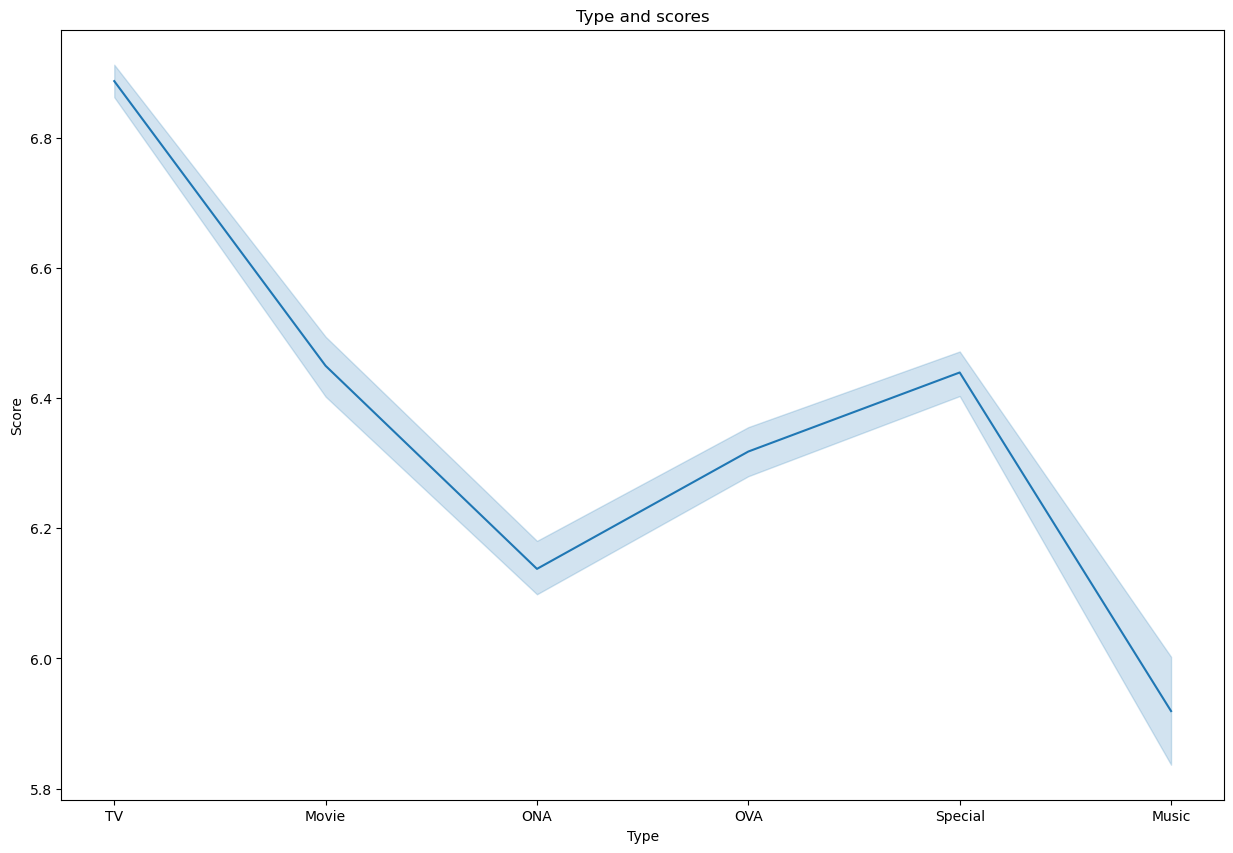

In [45]:
plt.figure(figsize=(15,10))
sns.lineplot(x=df_outliers['Type'], y= df_outliers['Score']).set(title = 'Type and scores')

As I thought it seems that tv type gets best scores and then movies, while ONA and music gets lowest scores which indeed are usually tent to be short in duration.

[Text(0.5, 1.0, 'Source and scores')]

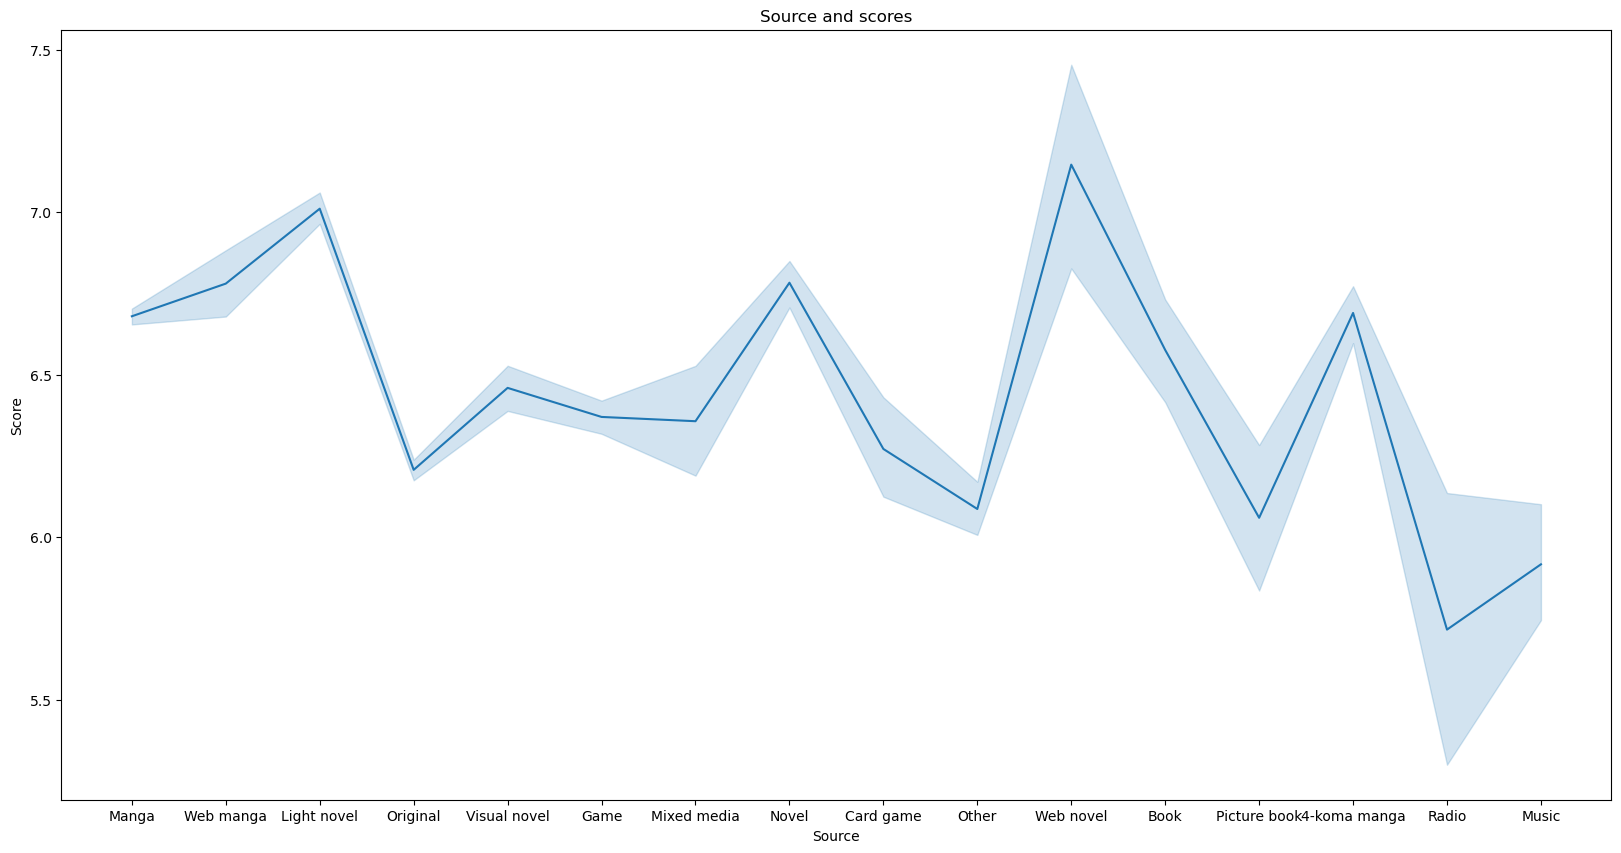

In [46]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df_outliers['Source'], y= df_outliers['Score']).set(title = 'Source and scores')

It seems that web novel and web manga gets the best scores, while radio and music gets ranked low.

In [47]:
print(len(df_outliers['Studio'].unique()))
len(df_outliers['Genres'].unique())

724


927

I had to skip studio and genres since they just have too many unique elements for me to be able to present them in a readable graph.

I also made a pairplot to be able to see the big picture all at once.

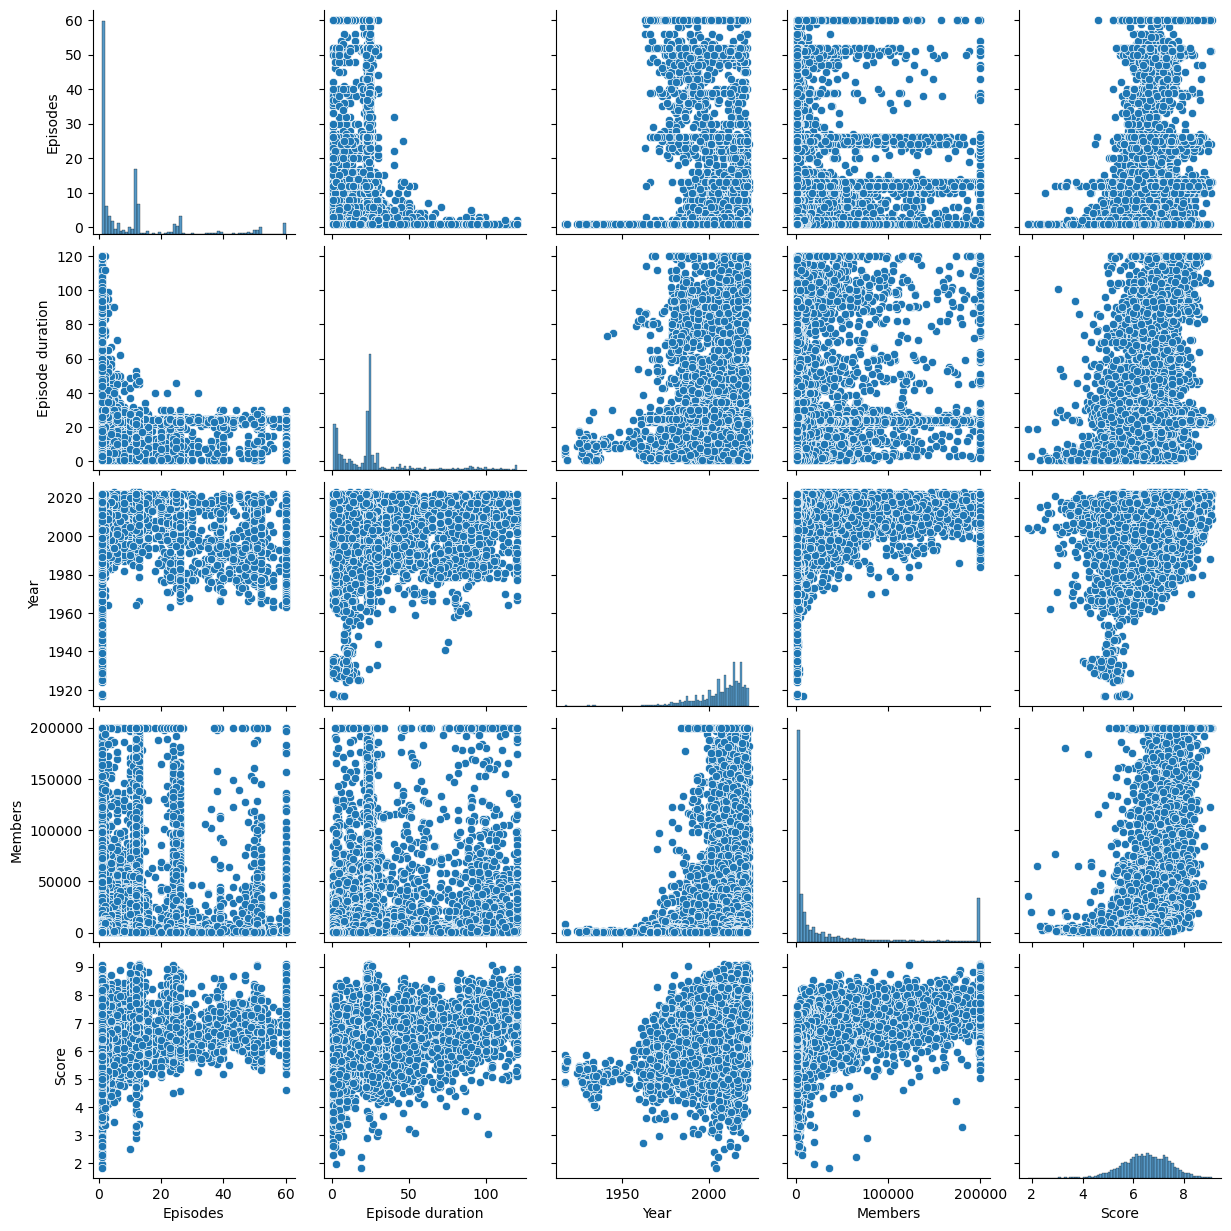

In [48]:
sns.pairplot(df_outliers)

I will also check how each column looks like after I removed the outliers from it.

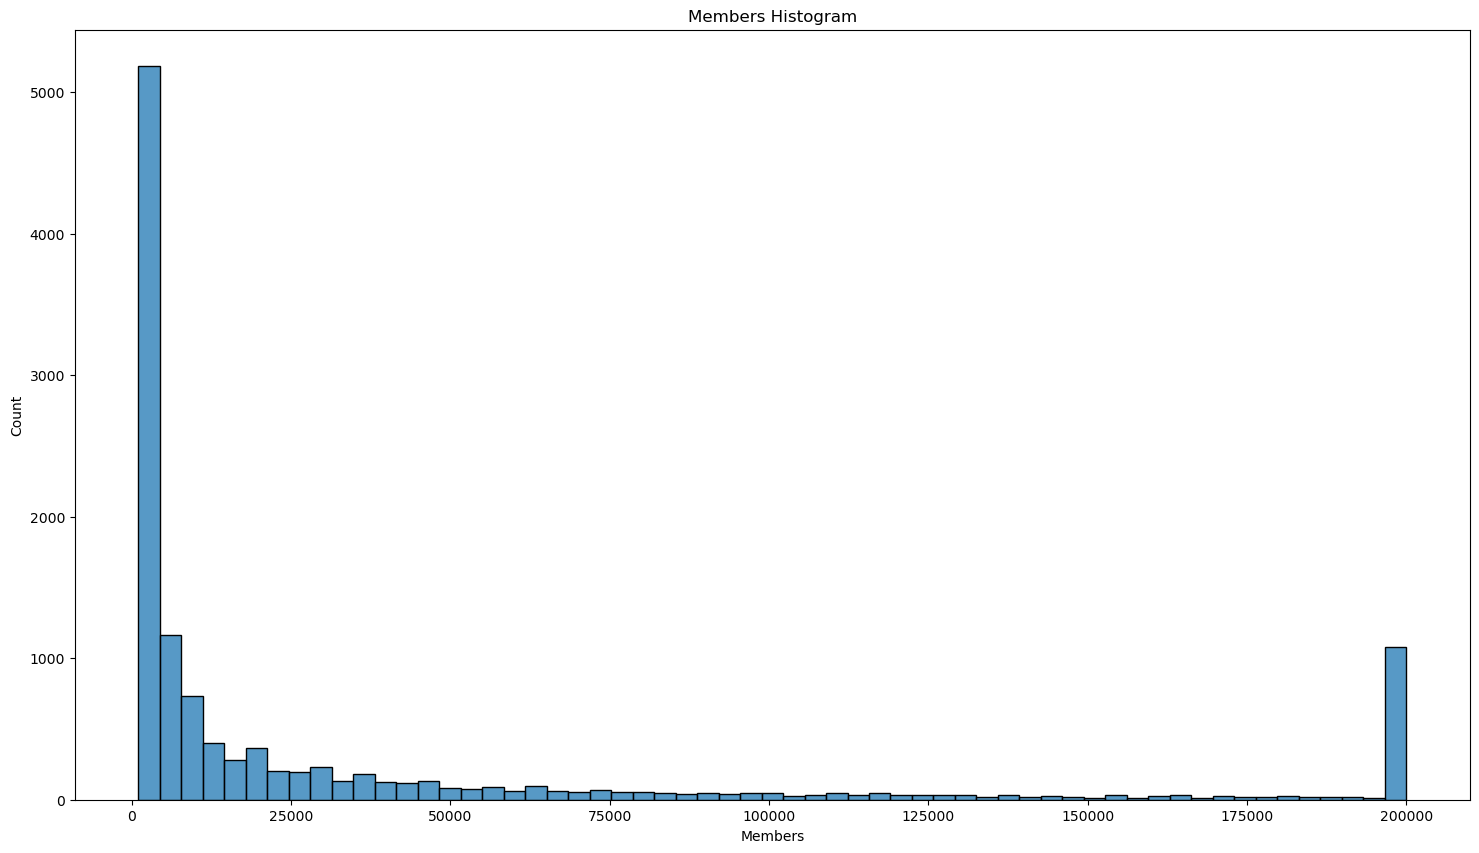

In [49]:
histogram_maker(df_outliers, 'Members')

<AxesSubplot:xlabel='Members'>

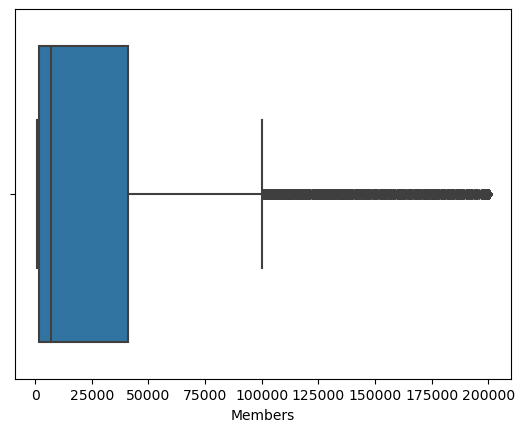

In [50]:
sns.boxplot(x=df_outliers['Members'])

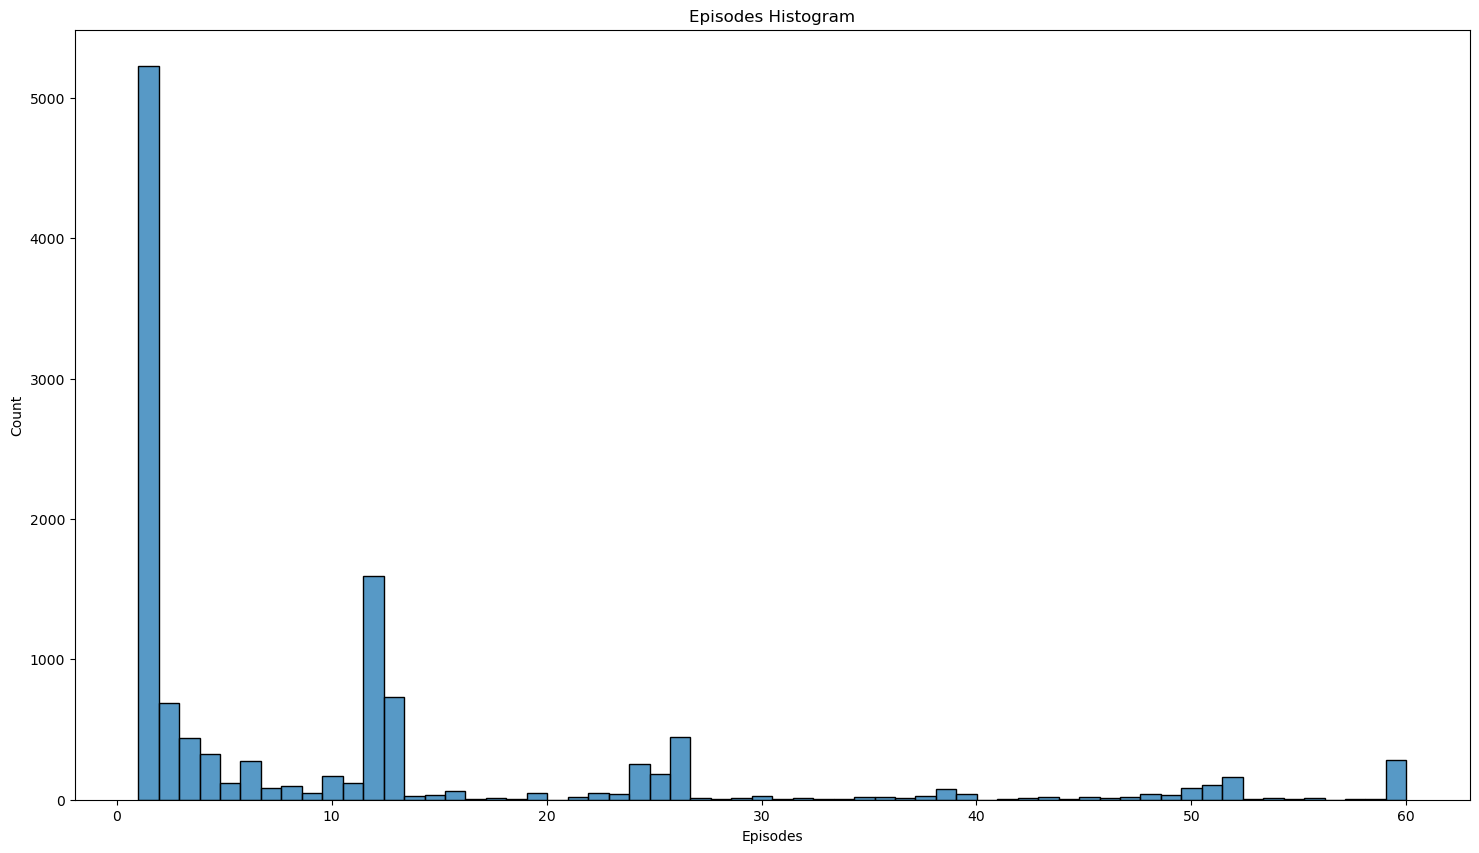

In [51]:
histogram_maker(df_outliers, 'Episodes')

<AxesSubplot:xlabel='Episodes'>

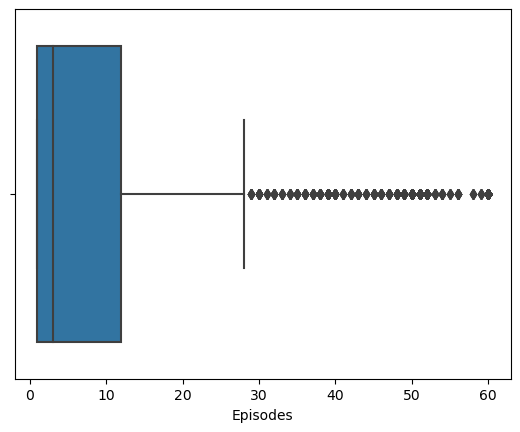

In [52]:
sns.boxplot(x=df_outliers['Episodes'])

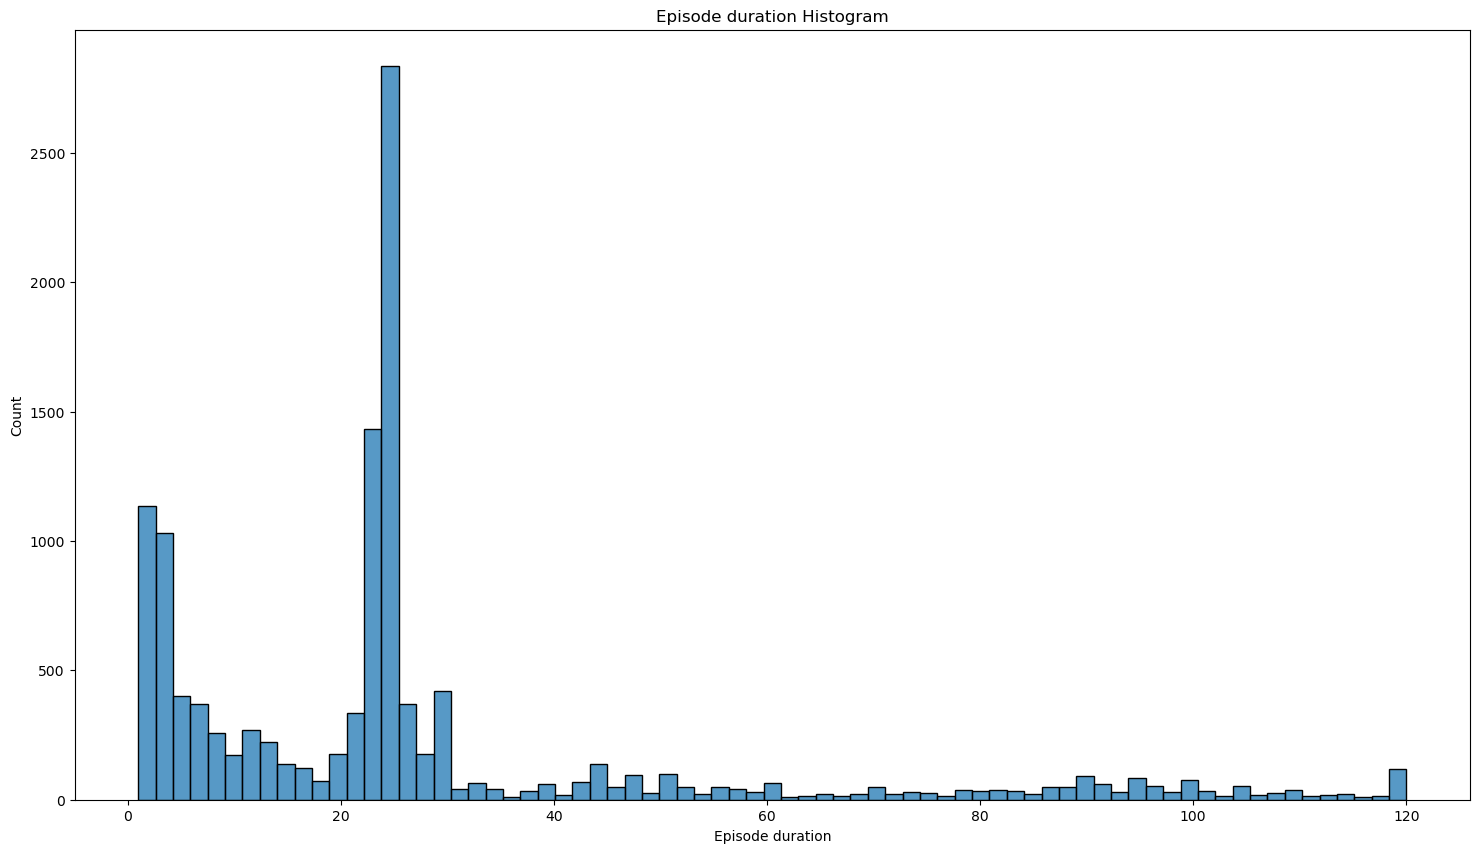

In [53]:
histogram_maker(df_outliers, 'Episode duration')

<AxesSubplot:xlabel='Episode duration'>

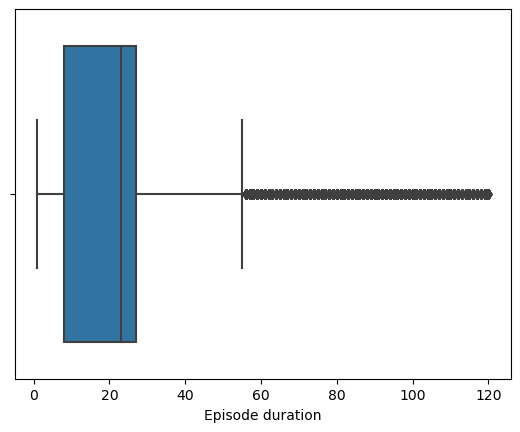

In [54]:
sns.boxplot(x=df_outliers['Episode duration'])

While there are still outliers according to the graphs I won't count them as such since removing them will ruin some the unique elements of the columns ( for example there will be no difference between 1 hour specials and movies if i set duration to max of 60), therefore I won't count those as outliers. 

The data looks much better now and should be ready for machine learning.

## Machine Learning model

In [55]:
df_final = df_outliers.copy()
df_final

,Titles,Type,Episodes,Episode duration,Year,Genres,Studio,Source,Members,Score
0,Shingeki no Kyojin,TV,25,24,2013,"Action,Award Winning,Drama,Suspense",Wit Studio,Manga,200000,8.53
1,Fullmetal Alchemist: Brotherhood,TV,60,24,2009,"Action,Adventure,Drama,Fantasy",Bones,Manga,200000,9.11
2,One Punch Man,TV,12,24,2015,"Action,Comedy",Madhouse,Web manga,200000,8.50
3,Sword Art Online,TV,25,23,2012,"Action,Adventure,Fantasy,Romance",A-1 Pictures,Light novel,200000,7.20
4,Boku no Hero Academia,TV,13,24,2016,Action,Bones,Manga,200000,7.91
...,...,...,...,...,...,...,...,...,...,...
34946,Bondage Game: Shinsou no Reijou-tachi - Shinso...,Special,1,26,2003,"Suspense,Hentai",ORADA COMPANY,Visual novel,2800,5.12
34971,Da Shi Jie,Movie,1,77,2018,Suspense,Unknown,Original,1000,5.82
34975,Boku no Sensou,Music,1,4,2022,Suspense,Rabbit Machine,Manga,1000,6.39
34982,Uchiko no Mama to Okaasan,ONA,1,1,2011,Suspense,Unknown,Original,1000,5.02


I have decided to use liner regression prediction model since as we learned in class this model is used for prediction of continuous numerical values, like in my case which is anime scores ranging from 0-10.

Firstly I will drop the title column as it is not needed for the prediction part of the project, I will also use label encoder to change all of the string enteries into numbers since the model know how to work only with numbers.

In [56]:
df_final = df_final.drop(['Titles'], axis=1)
cols = ['Type', 'Genres', 'Studio', 'Source']
df_final[cols]=df_final[cols].apply(LabelEncoder().fit_transform)

now I will split the data into train and test sets in order to be able to train my model.

In [57]:
x=df_final.drop('Score', axis=1)
y=df_final['Score']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [58]:
model = LinearRegression().fit(x_train_scaled, y_train)
y_predict = model.predict(x_test_scaled)

In [59]:
DF=pd.DataFrame({"Actual":y_test,"Predicted":y_predict})
print('the score of the model is:', r2_score(y_test, y_predict))
DF

the score of the model is: 0.44711928677391355


,Actual,Predicted
9284,4.02,6.057901
5501,6.72,6.496648
22231,6.12,5.936974
10158,7.35,6.983128
18337,6.28,5.548874
...,...,...
5728,7.31,6.655306
3352,6.30,6.753888
1332,6.62,6.302294
10137,7.52,6.764309


The model got a really low score, I will try to see if i can see why.

<AxesSubplot:xlabel='Score'>

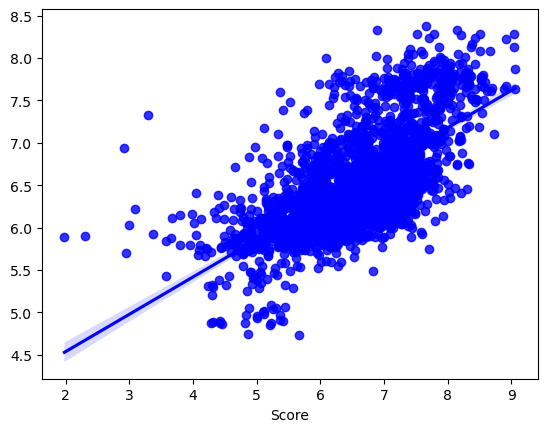

In [60]:
sns.regplot(x = y_test, y = y_predict, color = 'b')

In [61]:
df_final.corr()

,Type,Episodes,Episode duration,Year,Genres,Studio,Source,Members,Score
Type,1.000000,0.509391,-0.382287,0.140751,0.007451,-0.208284,-0.097885,0.279208,0.215708
Episodes,0.509391,1.000000,-0.177107,-0.078685,-0.109294,-0.043497,-0.040929,0.118838,0.235510
Episode duration,-0.382287,-0.177107,1.000000,-0.123566,-0.195055,-0.018829,-0.075153,0.113165,0.288814
Year,0.140751,-0.078685,-0.123566,1.000000,0.071891,-0.201701,0.000355,0.251465,0.238431
Genres,0.007451,-0.109294,-0.195055,0.071891,1.000000,0.023355,0.055388,-0.068289,-0.091395
Studio,-0.208284,-0.043497,-0.018829,-0.201701,0.023355,1.000000,0.058021,-0.207897,-0.202199
Source,-0.097885,-0.040929,-0.075153,0.000355,0.055388,0.058021,1.000000,-0.101877,-0.145081
Members,0.279208,0.118838,0.113165,0.251465,-0.068289,-0.207897,-0.101877,1.000000,0.556157
Score,0.215708,0.235510,0.288814,0.238431,-0.091395,-0.202199,-0.145081,0.556157,1.000000


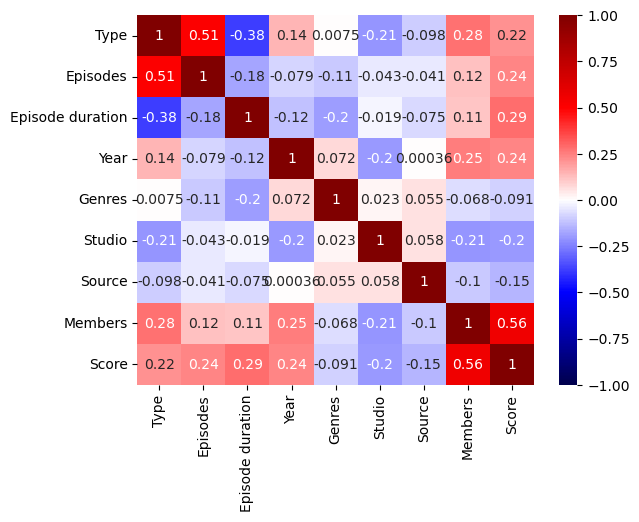

In [62]:
sns.heatmap(df_final.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [63]:
df_final.var()

Type                3.386307e+00
Episodes            2.081048e+02
Episode duration    6.884154e+02
Year                2.007965e+02
Genres              7.952987e+04
Studio              4.971621e+04
Source              8.587975e+00
Members             3.866814e+09
Score               8.365165e-01
dtype: float64

It seems that the correlation between the columns and target column (scores) isn't very strong other than members. and the big variance makes it hard for linear regression to predict the scores accurately.

After researching online about my issue I have found that there is a regression version of random forest that should be able to handle my data much better due to not being effect by variance as much and it also more suited to handle dataset that contain categorical variables and continous variables at the same time, since it can more accurately divide the data based on categorical variables.
I will now try to make such a model.

In [64]:
rf = RandomForestRegressor(random_state = 18).fit(x_train, y_train)
y_pred = rf.predict(x_test)
train_score = rf.score(x_train, y_train)
print('score on train:', train_score)
test_score = rf.score(x_test,y_test)
print('score on test:', test_score)

score on train: 0.9540139209486178
score on test: 0.6695983694929225


67%, accuracy That is indeed much better results and manage to create decent predictions, although it seems to overfit since scores on train and test having big diffrences between them, I will try to limit the trees max depth to remove the overfitting.

I will use the GridSearchCV function to look for best max depth, I will limit it to 7 to avoid still having overfitting.

In [65]:
parameters = {'max_depth':[3,4,5,6,7],
             'random_state': [18]}
rf_state = RandomForestRegressor()

clf = GridSearchCV(rf_state, parameters, scoring = 'r2')
clf.fit(x_train, y_train)

print("best parameter set is:",clf.best_params_," and its score was",clf.best_score_)

best parameter set is: {'max_depth': 7, 'random_state': 18}  and its score was 0.616964658917682


In [66]:
rf = RandomForestRegressor(max_depth = 7, random_state = 18).fit(x_train, y_train)
y_pred = rf.predict(x_test)
train_score = rf.score(x_train, y_train)
print('score on train:', train_score)
test_score = rf.score(x_test,y_test)
print('score on test:', test_score)

score on train: 0.6677516083999595
score on test: 0.6299669022855467


That is much better, no more overfitting.

I will try to see if I can imporve the model.
since the amount of genres for each anime range from 1-4 i had to put all genres together to avoid creating many missing values if I had seperated them, I will try to extract the main genre of each anime to see if that helps with the prediction.
I will also multiply the amount of episodes each anime have with the duration of each episode to create total length of the show. 

In [67]:
main_genre =[]
for genres in df_outliers['Genres']:
    genre = re.split(',', genres)
    main_genre.append(genre[0])

main_genre= LabelEncoder().fit_transform(main_genre)
df_final2 = df_final.copy()
df_final2['Main_genre']=main_genre

df_final2['Length'] = df_final2['Episodes'] * df_final2['Episode duration']

x2=df_final2.drop('Score', axis=1)
y2=df_final2['Score']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.2, random_state = 42)

rf2 = RandomForestRegressor(max_depth = 7, random_state = 18).fit(x_train2, y_train2)
y_pred2 = rf2.predict(x_test2)
train_score2 = rf2.score(x_train2, y_train2)
print('score on train:', train_score2)
test_score2 = rf2.score(x_test2,y_test2)
print('score on test:', test_score2)

score on train: 0.6733649059360902
score on test: 0.6356693250832941


In [68]:
DFT=pd.DataFrame({"Actual":y_test2,"Predicted":y_pred2})
DFT

,Actual,Predicted
9284,4.02,6.521699
5501,6.72,6.771757
22231,6.12,5.724729
10158,7.35,7.009718
18337,6.28,5.317448
...,...,...
5728,7.31,6.985580
3352,6.30,5.775907
1332,6.62,6.882627
10137,7.52,7.257586


It worked, adding those 2 new columns have improved the model.

Next I will check if maybe there are any columns that are better removed, i will use the feature_importance_ to check the "weight" of each column in the forest decision making to see which one had the least contribution to the model prediction.

In [69]:
features =['Type', 'Episodes', 'Episode duration', 'Year', 'Genres', 'Studio', 'Source', 'Members', 'Length', 'Main_genre']
featuresDF = pd.DataFrame({"features": features, "weights": rf2.feature_importances_})
featuresDF.sort_values("weights", ascending=False)

,features,weights
7,Members,0.691606
9,Main_genre,0.128541
3,Year,0.040547
2,Episode duration,0.039261
5,Studio,0.030365
0,Type,0.022662
6,Source,0.014916
4,Genres,0.014865
1,Episodes,0.014308
8,Length,0.002929


It seems as length had the least amount of contribution to the prediction, since I know that adding it improved the model, I have decided agianst removing any columns.

Next I will check if I can imporve the model further by adding n_estimators and max_features to the model.
I will look for best results by using GridSearchCV again.

In [70]:
parameters = {'n_estimators':range(100,1001,100),
             'max_features': ['sqrt', 'log2', 'auto', None],
             'random_state': [18]}
rf_best = RandomForestRegressor()

clf2 = GridSearchCV(rf_best, parameters)
clf2.fit(x_train2, y_train2)

print("best parameter set is:",clf2.best_params_," and its score was",clf2.best_score_)

best parameter set is: {'max_features': 'sqrt', 'n_estimators': 700, 'random_state': 18}  and its score was 0.6806659836194608


It worked by adding those parameters I have imporved the model prediction to 68%, That's a pretty decent model prediction scores.

## Conclusions

Predicting anime scores from the site myanimelist is hard task for several reasons.
1.each type of anime (tv,movie,music,etc...) have very different characteristic and behavior which makes prediction tricky( for example most movies, specials and music have only 1 episode which creates the huge spike in that area while most tv anime is either 12 or 24 seasons) that causes the data to be all over the places making it hard to predict, making a seperate project for each type will probably yield better results.
2.being user votes based scores means that its highly effect by human factor making some shows to have a very different score than what they should have in theory, for reasons such as the score going up from stuff like nostalgia, over hype or even people scoring bad shows very high as some gag, or a show score can be lower than it should from bad rep or not being very known. The prediction model can't account for these factors very well as they are irrational.

despite those difficulties, with proper data handling and knowldege of the data I have managed to get a decent prediction model of 68%.

## Credits

Some functions were taken from the campus IL course "Intro for Data Science".